<a href="https://colab.research.google.com/github/jlsm2/CIN0144-Equipe17/blob/main/Projeto_Aprendizado_de_Maquina_Equipe_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploração Inicial

## Importando bibliotecas

In [1]:
!pip install ucimlrepo # Necessario para importar o dataset
!pip install dalex


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dalex: filename=dalex-1.7.2-py3-none-any.whl size=1042898 sha256=7ff7afbbed8c51859d37958cbb501accd3a5d634836fd1ca3a9cd77dae4a4555
  Stored in directory: /root/.cache/pip/wheels/17/0a/3a/8c988bdca6acd7ce4aa949726b26c382ad1635e065bf83a175
Successfully built dalex


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dalex as dx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from ucimlrepo import fetch_ucirepo
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix
)

## Importação e tratamento inicial do dataset

In [3]:
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

# 1. Baixar o dataset
adult = fetch_ucirepo(id=2)
X_raw = adult.data.features
y_raw = adult.data.targets

# 2. Unir Features e Target em um único DataFrame para EDA
df = pd.concat([X_raw, y_raw], axis=1)

print(f"Dataset carregado. Dimensões iniciais: {df.shape}")
df.head()

Dataset carregado. Dimensões iniciais: (48842, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Limpeza inicial



In [4]:
# 1. Tratamento de Nulos
# O dataset usa '?' ou ' ?' para nulos. Vamos padronizar para NaN.
df = df.replace(['?', ' ?'], np.nan)

# 2. Tratamento da Variável Alvo (Income)
# Converter para binário: 0 (<=50K) e 1 (>50K)
# O uso de 'in str(x)' protege contra variações como '>50K.' (com ponto)
df['income'] = df['income'].apply(lambda x: 1 if '>50K' in str(x) else 0)

# 3. Remover Duplicatas
# Duplicatas distorcem a análise estatística
linhas_antes = df.shape[0]
df = df.drop_duplicates()
linhas_depois = df.shape[0]

print(f"Linhas duplicadas removidas: {linhas_antes - linhas_depois}")
print(f"Dimensões para análise: {df.shape}")

# 4. Verificar Nulos restantes
print("\nColunas com valores nulos:")
print(df.isnull().sum()[df.isnull().sum() > 0])

Linhas duplicadas removidas: 52
Dimensões para análise: (48790, 15)

Colunas com valores nulos:
workclass         2795
occupation        2805
native-country     856
dtype: int64


## EDA

### Desbalanceamento de classes

/tmp/ipython-input-727191944.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='income', data=df, palette='viridis')


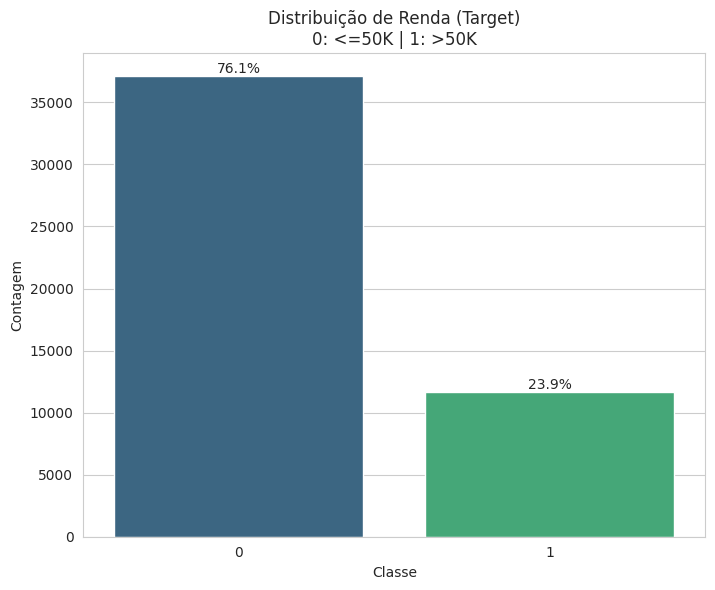

In [5]:
plt.figure(figsize=(20, 6))

# Gráfico 1: Desbalanceamento de Classes (O problema principal)
plt.subplot(1, 3, 1)
ax = sns.countplot(x='income', data=df, palette='viridis')
plt.title('Distribuição de Renda (Target)\n0: <=50K | 1: >50K')
plt.xlabel('Classe')
plt.ylabel('Contagem')
# Adicionar porcentagens
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Renda por sexo (atributo protegido)

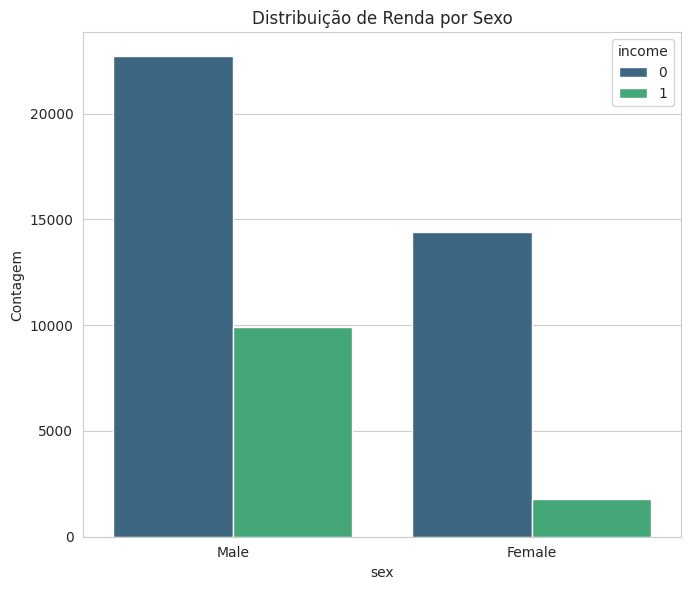

In [6]:
# Gráfico 2: Renda por Sexo (Atributo Protegido)
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 2)
sns.countplot(x='sex', hue='income', data=df, palette='viridis')
plt.title('Distribuição de Renda por Sexo')
plt.ylabel('Contagem')

plt.tight_layout()
plt.show()

### Renda por Raça (Atributo Protegido) - Focado nos grupos maiores

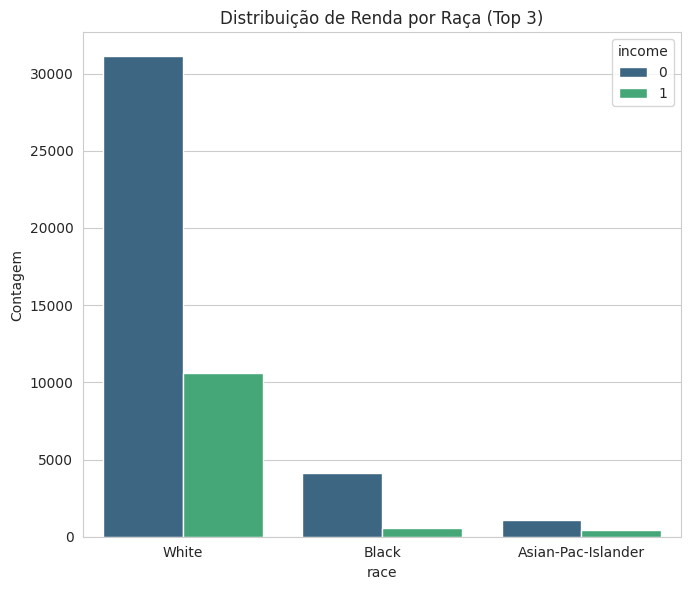

In [7]:
# Gráfico 3: Renda por Raça (Atributo Protegido) - Focado nos grupos maiores
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 3)
top_races = df['race'].value_counts().nlargest(3).index
sns.countplot(x='race', hue='income', data=df[df['race'].isin(top_races)], palette='viridis')
plt.title('Distribuição de Renda por Raça (Top 3)')
plt.ylabel('Contagem')

plt.tight_layout()
plt.show()

### Matriz de correlação numerica

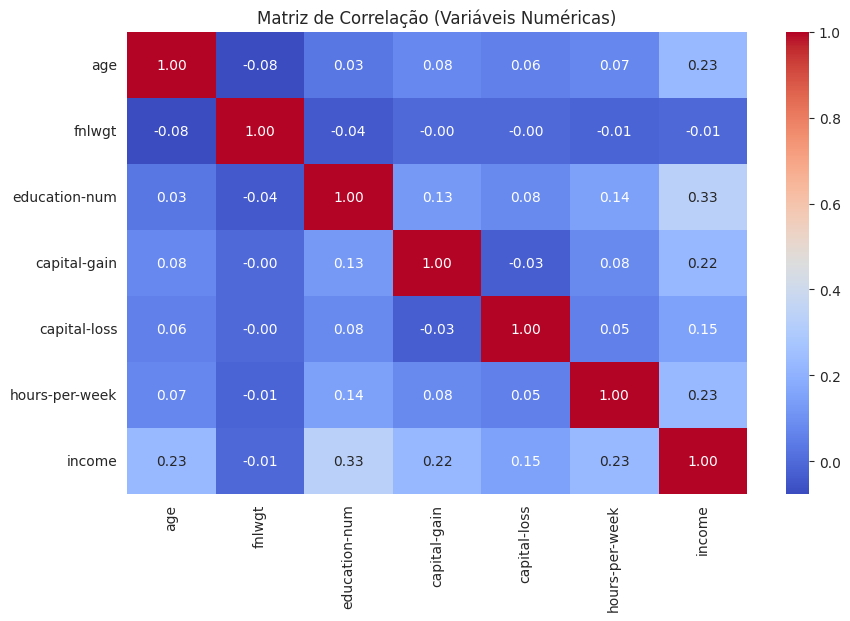

In [8]:
plt.figure(figsize=(10, 6))
numeric_cols = df.select_dtypes(include=['number']).columns
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação (Variáveis Numéricas)')
plt.show()

# Pre-processamento



## Separando features e target

In [9]:
X = df.drop('income', axis=1)
y = df['income']

print(f"X e y separados. Shape X: {X.shape}")
X

X e y separados. Shape X: (48790, 14)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States


In [10]:
y

,income
0,0
1,0
2,0
3,0
4,0
...,...
48837,0
48838,0
48839,0
48840,0


## Identificação das Colunas

In [11]:
# Listar colunas numéricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Listar colunas categóricas
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numéricas: {numeric_features}")
print(f"Categóricas: {categorical_features}")

Numéricas: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categóricas: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


## Criação dos pipelines com fit e transformação

In [12]:
# Regra para Números
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Regra para Categorias
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(
        handle_unknown='ignore',
        sparse_output=False
    ))
])


# Juntar as regras
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    verbose_feature_names_out=False
)

# ===============================
# DIVISÃO DOS DADOS (ANTES DO FIT)
# ===============================

X = df.drop('income', axis=1)
y = df['income']

# 1. Separar Teste (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# 2. Separar Treino (60%) e Validação (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

print(f"Treino: {X_train.shape} | Validação: {X_val.shape} | Teste: {X_test.shape}")

# ===============================
# APLICAR FIT APENAS NO TREINO
# ===============================

X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc   = preprocessor.transform(X_val)
X_test_proc  = preprocessor.transform(X_test)

# Recuperar nomes das features
cat_names = preprocessor.named_transformers_['cat']['onehot'] \
    .get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_names)

# Reconstruir DataFrames
X_train_proc = pd.DataFrame(X_train_proc, columns=feature_names, index=X_train.index)
X_val_proc   = pd.DataFrame(X_val_proc, columns=feature_names, index=X_val.index)
X_test_proc  = pd.DataFrame(X_test_proc, columns=feature_names, index=X_test.index)


Treino: (29274, 14) | Validação: (9758, 14) | Teste: (9758, 14)


## Aplicando SMOTE e Undersampling




In [13]:
# ===============================
# BALANCEAMENTO DOS DADOS (TREINO)
# ===============================

# Garantir alinhamento de índices
y_train = y_train.reset_index(drop=True)

# SMOTE (Oversampling)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_proc, y_train)

X_train_smote = pd.DataFrame(
    X_train_smote,
    columns=feature_names,
    index=range(len(X_train_smote))
)

# Undersampling (RUS)
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_proc, y_train)

X_train_rus = pd.DataFrame(
    X_train_rus,
    columns=feature_names,
    index=range(len(X_train_rus))
)

# Garantir ausência de NaN (necessário após RUS)
X_train_rus = X_train_rus.fillna(0)


print(f"Original: {Counter(y_train)}")
print(f"SMOTE:    {Counter(y_train_smote)}")
print(f"RUS:      {Counter(y_train_rus)}")


Original: Counter({0: 22265, 1: 7009})
SMOTE:    Counter({0: 22265, 1: 22265})
RUS:      Counter({0: 7009, 1: 7009})


## Tunagem de Hiperparâmetros

In [14]:
# Definir o Grid de Hiperparâmetros
param_grid_lr = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["liblinear", "lbfgs"]
}

# Configurar o GridSearchCV
grid_lr = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000, random_state=42),
    param_grid=param_grid_lr,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

grid_lr.fit(X_train_smote, y_train_smote)

print("Melhores hiperparâmetros (LR):", grid_lr.best_params_)
print(f"Melhor Score (AUC): {grid_lr.best_score_:.4f}")

# Salvar o melhor modelo encontrado
best_lr = grid_lr.best_estimator_

Melhores hiperparâmetros (LR): {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Melhor Score (AUC): 0.9083


In [15]:
param_dist_rf = {
    "n_estimators": randint(100, 400),
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 5)
}

random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist_rf,
    n_iter=10,
    scoring="roc_auc",
    cv=2,
    random_state=42,
    n_jobs=-1
)
random_search_rf.fit(X_train_smote, y_train_smote)

print("Melhores hiperparâmetros (RF):", random_search_rf.best_params_)
print(f"Melhor Score (AUC): {random_search_rf.best_score_:.4f}")

best_rf = random_search_rf.best_estimator_

Melhores hiperparâmetros (RF): {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 393}
Melhor Score (AUC): 0.9461


In [16]:
param_dist_knn = {
    "n_neighbors": [5, 11, 21, 31],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean"]
}

random_search_knn = RandomizedSearchCV(
    estimator=KNeighborsClassifier(n_jobs=-1),
    param_distributions=param_dist_knn,
    n_iter=6,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1
)

random_search_knn.fit(X_train_smote, y_train_smote)

print("Melhores hiperparâmetros (kNN):", random_search_knn.best_params_)
print(f"Melhor Score (AUC): {random_search_knn.best_score_:.4f}")

best_knn = random_search_knn.best_estimator_

Melhores hiperparâmetros (kNN): {'weights': 'distance', 'n_neighbors': 11, 'metric': 'euclidean'}
Melhor Score (AUC): 0.9432


# Modelos e métricas

In [17]:
models_tuned = {
    "Logistic Regression (Tuned)": best_lr,
    "Random Forest (Tuned)": best_rf,
    "kNN (Tuned)": best_knn
}


In [18]:
def train_and_evaluate_processed(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred))
    print("AUC-ROC:", roc_auc_score(y_test, y_proba))

    return model


In [19]:
print("=== MODELOS SEM BALANCEAMENTO (DADOS ORIGINAIS) ===\n")

trained_models = {}

for name, model in models_tuned.items():
    print(f"Modelo: {name}")

    trained_models[name] = train_and_evaluate_processed(
        model,
        X_train_proc,
        y_train,
        X_test_proc,
        y_test
    )
    print("-" * 50)

=== MODELOS SEM BALANCEAMENTO (DADOS ORIGINAIS) ===

Modelo: Logistic Regression (Tuned)
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      7422
           1       0.74      0.62      0.67      2336

    accuracy                           0.85      9758
   macro avg       0.81      0.77      0.79      9758
weighted avg       0.85      0.85      0.85      9758

AUC-ROC: 0.9084713324510988
--------------------------------------------------
Modelo: Random Forest (Tuned)
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      7422
           1       0.78      0.64      0.70      2336

    accuracy                           0.87      9758
   macro avg       0.83      0.79      0.81      9758
weighted avg       0.86      0.87      0.86      9758

AUC-ROC: 0.9207331591012281
--------------------------------------------------
Modelo: kNN (Tuned)
              precision    recall  f1-score   sup

In [20]:
# ======================================================
# AVALIAÇÃO COM SMOTE (SEM TUNAGEM DE HIPERPARÂMETROS)
# ======================================================

models_default = {
    "Logistic Regression (Default)": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest (Default)": RandomForestClassifier(random_state=42, n_jobs=-1),
    "kNN (Default)": KNeighborsClassifier()
}

print("=== MODELOS COM SMOTE (SEM TUNAGEM) ===\n")

trained_models_smote_default = {}

for name, model in models_default.items():
    print(f"Modelo: {name}")

    model.fit(X_train_smote, y_train_smote)

    y_pred  = model.predict(X_test_proc)
    y_proba = model.predict_proba(X_test_proc)[:, 1]

    print(classification_report(y_test, y_pred))
    print("AUC-ROC:", roc_auc_score(y_test, y_proba))
    print("-" * 50)

    trained_models_smote_default[name] = model


=== MODELOS COM SMOTE (SEM TUNAGEM) ===

Modelo: Logistic Regression (Default)
              precision    recall  f1-score   support

           0       0.94      0.79      0.86      7422
           1       0.56      0.84      0.68      2336

    accuracy                           0.81      9758
   macro avg       0.75      0.82      0.77      9758
weighted avg       0.85      0.81      0.82      9758

AUC-ROC: 0.9074443273976295
--------------------------------------------------
Modelo: Random Forest (Default)
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      7422
           1       0.67      0.69      0.68      2336

    accuracy                           0.84      9758
   macro avg       0.79      0.79      0.79      9758
weighted avg       0.85      0.84      0.85      9758

AUC-ROC: 0.8999352685739914
--------------------------------------------------
Modelo: kNN (Default)
              precision    recall  f1-score   support



In [21]:
print("=== MODELOS TUNADOS (SMOTE) ===\n")

trained_models_tuned = {}

for name, model in models_tuned.items():
    print(f"Modelo: {name}")
    trained_models_tuned[name] = train_and_evaluate_processed(
        model,
        X_train_smote,
        y_train_smote,
        X_test_proc,
        y_test
    )
    print("-" * 50)


=== MODELOS TUNADOS (SMOTE) ===

Modelo: Logistic Regression (Tuned)
              precision    recall  f1-score   support

           0       0.94      0.79      0.86      7422
           1       0.56      0.84      0.67      2336

    accuracy                           0.81      9758
   macro avg       0.75      0.82      0.77      9758
weighted avg       0.85      0.81      0.82      9758

AUC-ROC: 0.9074293889325699
--------------------------------------------------
Modelo: Random Forest (Tuned)
              precision    recall  f1-score   support

           0       0.93      0.85      0.89      7422
           1       0.63      0.79      0.70      2336

    accuracy                           0.84      9758
   macro avg       0.78      0.82      0.79      9758
weighted avg       0.86      0.84      0.84      9758

AUC-ROC: 0.9139842028327482
--------------------------------------------------
Modelo: kNN (Tuned)
              precision    recall  f1-score   support

           0  

In [22]:
print("=== MODELOS COM UNDERSAMPLING ===\n")

trained_models_under = {}

for name, model in models_tuned.items():
    print(f"Modelo: {name}")
    trained_models_under[name] = train_and_evaluate_processed(
        model,
        X_train_rus,
        y_train_rus,
        X_test_proc,
        y_test
    )
    print("-" * 50)


=== MODELOS COM UNDERSAMPLING ===

Modelo: Logistic Regression (Tuned)
              precision    recall  f1-score   support

           0       0.77      0.46      0.57      7422
           1       0.24      0.55      0.34      2336

    accuracy                           0.48      9758
   macro avg       0.50      0.51      0.46      9758
weighted avg       0.64      0.48      0.52      9758

AUC-ROC: 0.4912678615593035
--------------------------------------------------
Modelo: Random Forest (Tuned)
              precision    recall  f1-score   support

           0       0.77      0.50      0.60      7422
           1       0.24      0.52      0.33      2336

    accuracy                           0.50      9758
   macro avg       0.51      0.51      0.47      9758
weighted avg       0.64      0.50      0.54      9758

AUC-ROC: 0.5078558446196609
--------------------------------------------------
Modelo: kNN (Tuned)
              precision    recall  f1-score   support

           0

## Grafico de Incerteza


--- Distribuição de Incerteza: Cenário Original (Desbalanceado) ---


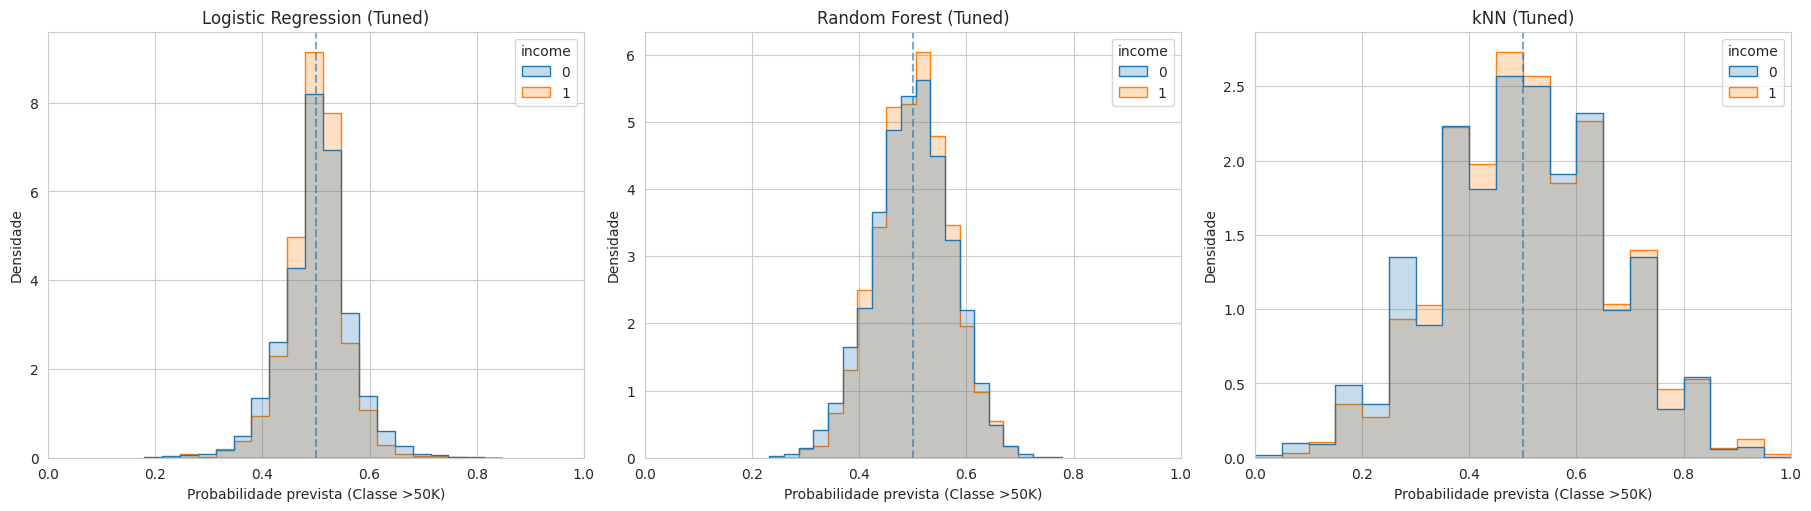


--- Distribuição de Incerteza: Cenário SMOTE sem tunagem ---


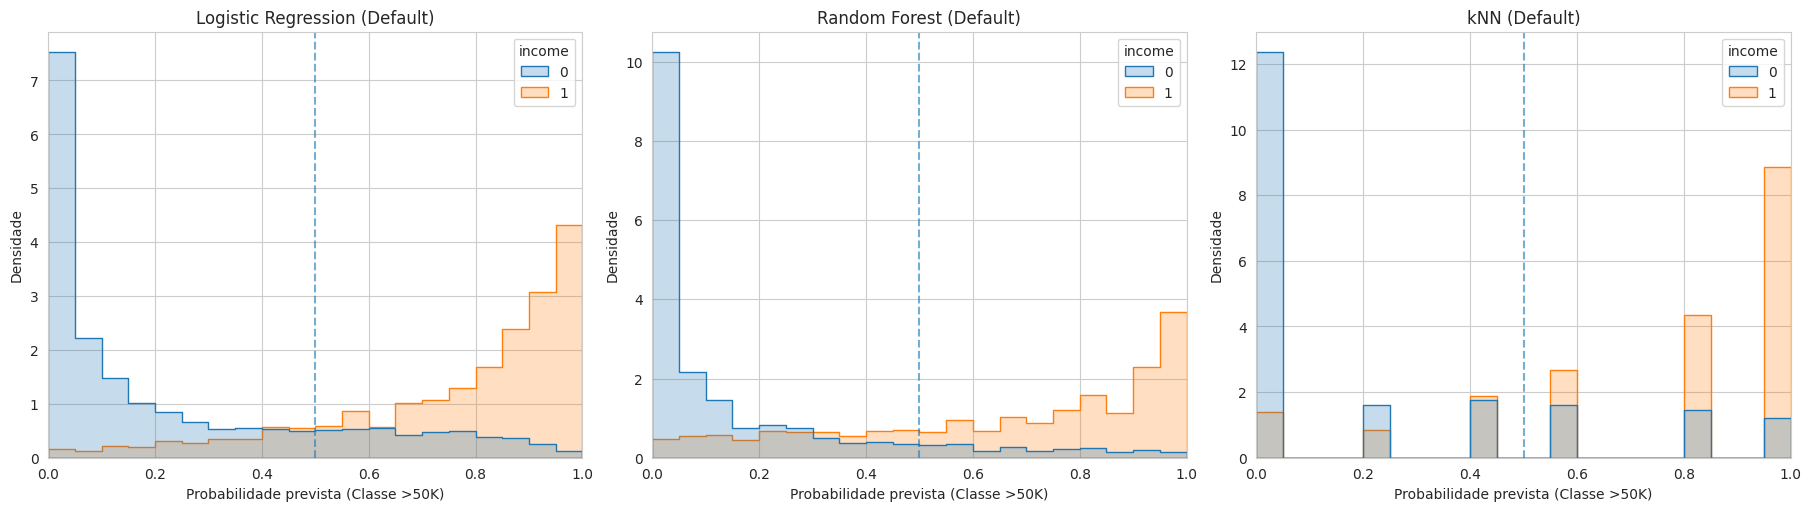


--- Distribuição de Incerteza: Cenário Balanceado (SMOTE) com tunagem ---


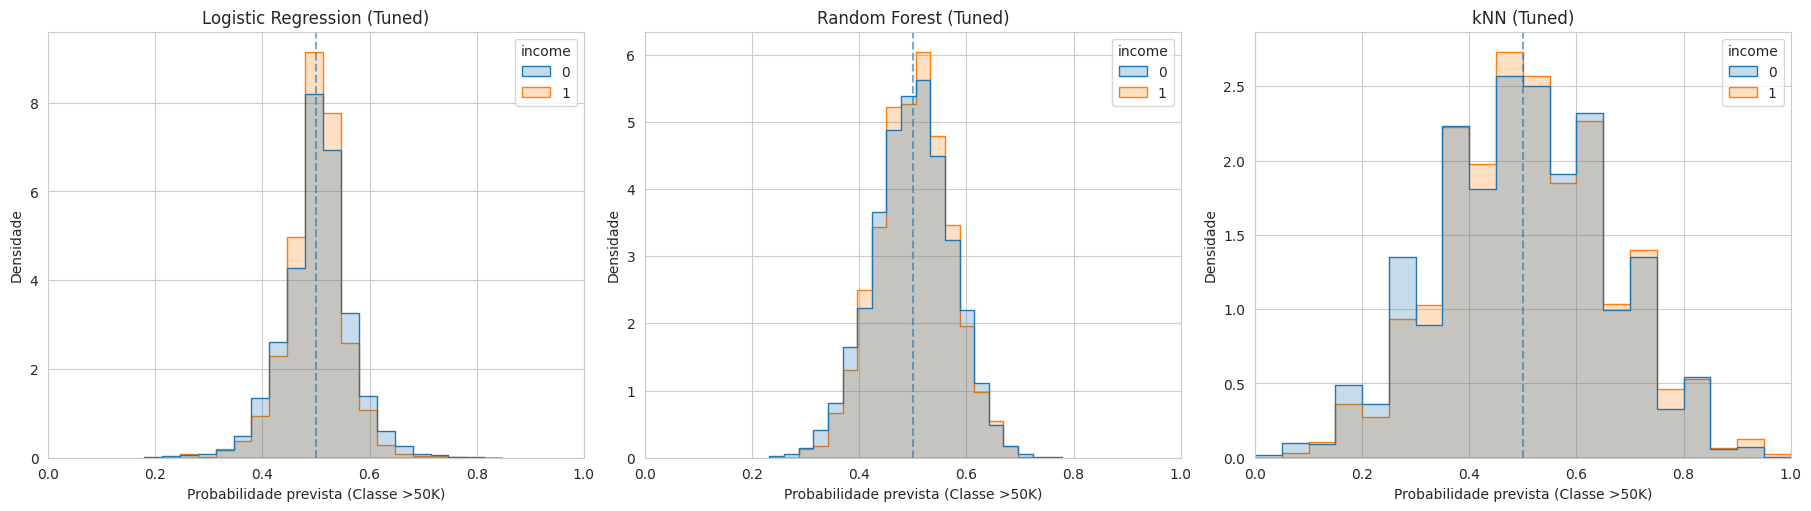


--- Distribuição de Incerteza: Cenário Balanceado (RUS) ---


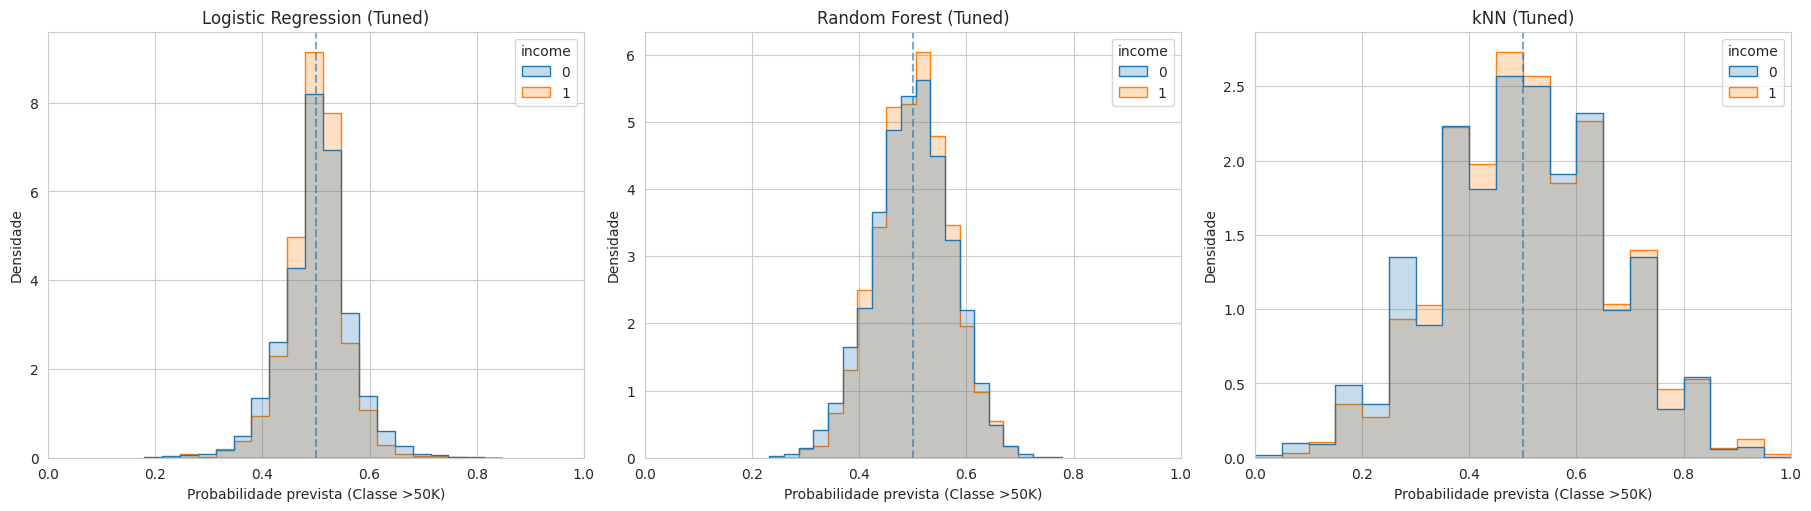

In [30]:
def plot_uncertainty_distribution(models_dict, X_test_proc, y_test, scenario_name):
    print(f"\n--- Distribuição de Incerteza: Cenário {scenario_name} ---")

    n_models = len(models_dict)
    fig, axes = plt.subplots(
        1, n_models,
        figsize=(6 * n_models, 5),
        constrained_layout=True
    )

    if n_models == 1:
        axes = [axes]

    for ax, (name, model) in zip(axes, models_dict.items()):
        if not hasattr(model, "predict_proba"):
            print(f"Modelo {name} não suporta predict_proba. Pulando.")
            continue

        # SEMPRE usar dados processados
        y_proba = model.predict_proba(X_test_proc)[:, 1]

        sns.histplot(
            x=y_proba,
            hue=y_test,
            element="step",
            stat="density",
            common_norm=False,
            bins=20,
            ax=ax
        )

        ax.set_title(name)
        ax.set_xlabel("Probabilidade prevista (Classe >50K)")
        ax.set_ylabel("Densidade")
        ax.set_xlim(0, 1)

        # Threshold padrão
        ax.axvline(0.5, linestyle='--', alpha=0.6)

    plt.show()


# 1. Modelos Originais (Sem Balanceamento)
if 'trained_models' in locals():
    plot_uncertainty_distribution(
        trained_models,
        X_test_proc,
        y_test,
        "Original (Desbalanceado)"
    )

# 2. Modelos com SMOTE sem tunagem
if 'trained_models_smote_default' in locals():
    plot_uncertainty_distribution(
        trained_models_smote_default,
        X_test_proc,
        y_test,
        "SMOTE sem tunagem"
    )

# 2. Modelos com SMOTE tunado
if 'trained_models_tuned' in locals():
    plot_uncertainty_distribution(
        trained_models_tuned,
        X_test_proc,
        y_test,
        "Balanceado (SMOTE) com tunagem"
    )

# 3. Modelos com Undersampling tunado
if 'trained_models_under' in locals():
    plot_uncertainty_distribution(
        trained_models_under,
        X_test_proc,
        y_test,
        "Balanceado (RUS)"
    )


## Análise de justiça

In [31]:
# ANÁLISE DE JUSTIÇA (FAIRNESS)

# Modelo escolhido: Random Forest treinado com SMOTE
fair_model = trained_models_tuned["Random Forest (Tuned)"]

# Predições no conjunto de teste (processado)
y_pred_fair = fair_model.predict(X_test_proc)

# Construir DataFrame mínimo para fairness
fair_df = pd.DataFrame(index=X_test_proc.index)

# Reconstruir atributo sensível (sexo)
fair_df["sex"] = X_test_proc["sex_Male"].apply(
    lambda x: "Male" if x == 1.0 else "Female"
)

# Adicionar rótulo verdadeiro e predição
fair_df["y_true"] = y_test.values
fair_df["y_pred"] = y_pred_fair

print("Distribuição do atributo sensível (sexo) no teste:")
print(fair_df["sex"].value_counts(normalize=True))


Distribuição do atributo sensível (sexo) no teste:
sex
Male      0.659151
Female    0.340849
Name: proportion, dtype: float64


In [25]:
# Modelo escolhido para análise de justiça
fair_model = trained_models_tuned["Random Forest (Tuned)"]

# Criar explainer do modelo
explainer = dx.Explainer(
    fair_model,
    X_test_proc,
    y_test,
    label="Random Forest (SMOTE)"
)


Preparation of a new explainer is initiated

  -> data              : 9758 rows 104 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 9758 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Random Forest (SMOTE)
  -> predict function  : <function yhat_proba_default at 0x7abf4f0c74c0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.232, mean = 0.5, max = 0.778
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.778, mean = -0.26, max = 0.71
  -> model_info        : package sklearn

A new explainer has been created!


In [33]:

# FAIRNESS COM DALEX
# Criar DataFrame mínimo para fairness a partir do conjunto processado
fair_df = pd.DataFrame(index=X_test_proc.index)

# Reconstruir atributo sensível (sexo)
fair_df["sex"] = X_test_proc["sex_Male"].apply(
    lambda x: "Male" if x == 1.0 else "Female"
)

# Calcular métricas de justiça
fairness = explainer.model_fairness(
    protected=fair_df["sex"],
    privileged="Male"
)

fairness.metric_scores


,TPR,TNR,PPV,NPV,FNR,FPR,FDR,FOR,ACC,STP
Female,0.389,0.509,0.093,0.865,0.611,0.491,0.907,0.135,0.495,0.479
Male,0.541,0.491,0.317,0.710,0.459,0.509,0.683,0.290,0.506,0.519


## Comparação de justiça

In [32]:
# COMPARAÇÃO DE JUSTIÇA: RF BASELINE vs RF + SMOTE

# Reconstruir variável sensível a partir do conjunto PROCESSADO
protected_df = pd.DataFrame(index=X_test_proc.index)

protected_df["sex"] = X_test_proc["sex_Male"].apply(
    lambda x: "Male" if x == 1.0 else "Female"
)

protected_vec = protected_df["sex"]

# -------------------------------
# Modelo A: Random Forest ORIGINAL (sem balanceamento)
# -------------------------------
rf_original = trained_models["Random Forest (Tuned)"]

exp_orig = dx.Explainer(
    rf_original,
    X_test_proc,
    y_test,
    label="RF Original (Desbalanceado)",
    verbose=False
)

# -------------------------------
# Modelo B: Random Forest com SMOTE
# -------------------------------
rf_smote = trained_models_tuned["Random Forest (Tuned)"]

exp_smote = dx.Explainer(
    rf_smote,
    X_test_proc,
    y_test,
    label="RF com SMOTE",
    verbose=False
)

# -------------------------------
# Cálculo das Métricas de Justiça
# -------------------------------
fobject_orig = exp_orig.model_fairness(
    protected=protected_vec,
    privileged="Male"
)

fobject_smote = exp_smote.model_fairness(
    protected=protected_vec,
    privileged="Male"
)

# -------------------------------
# Comparação Visual
# -------------------------------
fobject_orig.plot(fobject_smote)


/usr/local/lib/python3.12/dist-packages/dalex/fairness/_group_fairness/utils.py:209: FutureWarning:

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.

/usr/local/lib/python3.12/dist-packages/dalex/fairness/_group_fairness/utils.py:209: FutureWarning:

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.

